Iris data 는 네 종류의 변수를 이용하여 Iris 의 품종을 예측하는데 이용되는 데이터입니다. Scikit-learn 에서도 해당 데이터를 제공하며, `data` 와 `target` 자체가 numpy.ndarray 로 정제되어 있습니다. 이를 pandas DataFrame 으로 변환하여 데이터를 살펴봅니다.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.datasets import load_iris

iris = load_iris()
print(f'iris keys = {iris.keys()}')

X = iris['data']
labels = iris['target']

# ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
columns = [name[:-5].replace(' ', '_') for name in iris['feature_names']]
iris_df = pd.DataFrame(data=iris.data, columns=columns)
iris_df['labels'] = labels
iris_df.head(5)

iris keys = dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])


,sepal_length,sepal_width,petal_length,petal_width,labels
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


데이터마다 스캐일에 차이가 있습니다. 이를 min-max scaler 를 이용하여 이를 정규화 합니다.

In [2]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
X[:2]

array([[0.22222222, 0.625     , 0.06779661, 0.04166667],
       [0.16666667, 0.41666667, 0.06779661, 0.04166667]])

UMAP 을 이용하여 4차원의 데이터를 2차원으로 구분합니다. `target_weight` 를 설정하면 labels 의 영향력을 조절할 수 있습니다.

/home/lovit/anaconda3/envs/pytorch/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


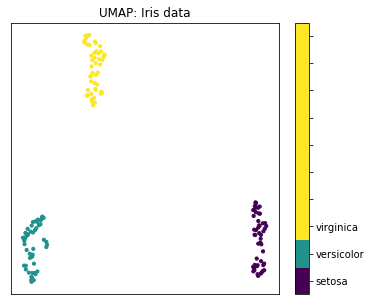

In [3]:
import umap

xy = umap.UMAP(n_neighbors=10, target_weight=0.1).fit_transform(X, y=labels)

def draw(xy, classes, color, title):    
    fig, ax = plt.subplots(1, figsize=(6, 5))
    plt.scatter(xy[:,0], xy[:,1], s=10, c=color, alpha=1.0)
    plt.setp(ax, xticks=[], yticks=[])
    cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
    cbar.set_ticks(np.arange(10))
    cbar.set_ticklabels(classes)
    plt.title(title)
    return fig

classes = list(iris.target_names)
title = 'UMAP: Iris data'
fig = draw(xy, classes, labels, title)

그런데 레이블 정보를 이용하지 않아도 PCA 를 통하여 2차원 벡터를 학습해보니 종별로 어느 정도 구분이 됩니다. 즉 PCA 를 이용하여 변수를 2개로 줄이더라도 classifier models 이 잘 학습될 가능성이 높습니다.

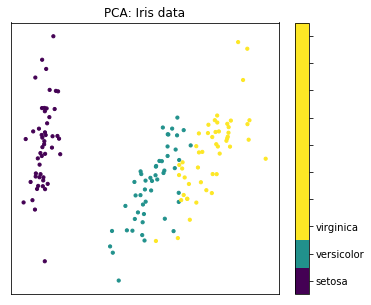

In [4]:
from sklearn.decomposition import PCA

xy = PCA(n_components=2).fit_transform(X)
title = 'PCA: Iris data'
fig = draw(xy, classes, labels, title)

t-SNE 를 이용하여 학습한 경우에도 어느 정도 클래스가 구분되어 2차원 벡터로 표현됩니다. 즉 Iris data 는 판별 문제에 매우 쉬운 데이터라는 의미입니다.

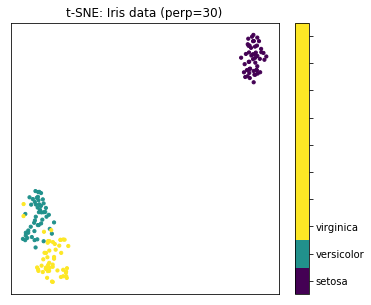

In [5]:
from sklearn.manifold import TSNE

xy = TSNE(n_components=2, perplexity=30).fit_transform(X)
title = 't-SNE: Iris data (perp=30)'
fig = draw(xy, classes, labels, title)

Perplexity 를 아주 작게 줄여보니 그 구분이 조금 약하고, 몇몇 점들이 튕겨져 나가듯이 그림이 그려집니다. 이는 perplexity 의 수치가 매우 작기 때문에 임베딩 모델이 잘 학습되지 않은 것입니다.

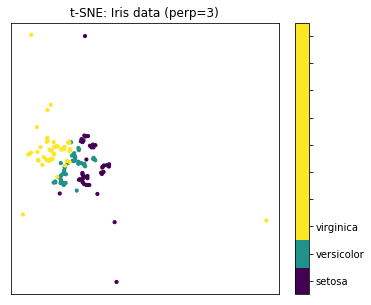

In [6]:
from sklearn.manifold import TSNE

np.random.seed(2)
xy = TSNE(n_components=2, perplexity=3).fit_transform(X)
title = 't-SNE: Iris data (perp=3)'
fig = draw(xy, classes, labels, title)